In [2]:
import sys, os
sys.path.append(os.path.realpath(".."))

import util_funcs
from importlib import reload
reload(util_funcs)
from copy import deepcopy as cp

import data_reader as read
import pandas as pd
import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt
import pywt
import tsfresh.feature_extraction.feature_calculators as feats
import constants
import clinical_text_analysis as cta
reload(cta)
import tsfresh

from os import path

reload(read)
import wf_analysis.datasets as wfdata
import wf_analysis.filters as filt
reload(filt)
import time

In [2]:
edfDatum = edfData[0][0]

In [3]:
edfDatum

,EEG T5-REF,EEG C3-REF,EEG A1-REF,EEG P4-REF,EEG F8-REF,EEG F3-REF,EEG CZ-REF,EEG O2-REF,EEG A2-REF,EEG P3-REF,...,EEG O1-REF,EEG T4-REF,EEG F4-REF,EEG F7-REF,EEG PZ-REF,EEG FP1-REF,EEG FZ-REF,EEG T3-REF,EEG T6-REF,EEG FP2-REF
00:00:00,35.157700,32.197906,38.789350,61.759533,16.672604,24.989081,36.810101,33.450825,26.260159,61.850325,...,16.745237,21.103216,-7.586816,13.367803,20.376886,-46.082301,19.468974,27.767293,33.922939,-84.922794
00:00:00.008000,57.922281,38.969202,50.701591,81.700298,14.326072,29.744850,47.791571,49.755012,31.837067,81.812128,...,33.518013,21.671860,-15.627683,13.469450,33.996420,-58.177424,21.365785,35.872444,43.599821,-110.775992
00:00:00.016000,61.102378,25.182308,45.431818,68.872260,8.302728,18.186897,39.484468,55.041885,30.934949,66.718345,...,46.549221,22.282554,-16.492458,9.674614,40.016883,-47.659282,13.220255,30.926433,43.235535,-86.479187
00:00:00.024000,70.292855,30.221475,58.372040,78.784754,15.319285,20.159488,44.909037,66.594911,40.005480,74.576315,...,57.910219,30.091795,-14.127180,15.183872,46.136450,-51.553136,14.291568,39.453247,53.584935,-90.666224
00:00:00.032000,86.737198,47.049891,79.837766,94.442382,10.180839,26.976896,56.931572,75.025017,39.132601,100.328233,...,63.076943,24.848606,-22.916307,19.305314,49.012033,-73.480071,19.192458,50.068372,57.334512,-139.163078
00:00:00.040000,77.907799,34.622605,65.293783,65.275325,-8.514003,15.601967,40.379553,62.030909,21.689688,78.194559,...,61.301256,6.468142,-25.503679,6.071447,39.080330,-62.738970,10.316063,43.156264,38.303807,-117.586561
00:00:00.048000,72.459834,33.920470,63.391849,71.589136,2.867055,17.980660,43.390136,65.228457,36.281204,78.472831,...,61.800691,19.985018,-21.136011,11.061588,39.659288,-65.030216,13.200519,43.020130,46.591814,-115.028169
00:00:00.056000,60.606334,33.827936,51.221894,73.125609,14.980636,21.191392,42.234113,58.664524,48.255391,70.917505,...,57.005267,26.342672,-13.311394,8.789505,35.777823,-61.363683,15.413449,32.640742,46.659624,-106.924270
00:00:00.064000,51.212477,35.973433,50.324400,66.511278,14.609618,27.163575,42.334230,46.135348,42.909180,70.134385,...,44.941506,25.244217,-13.979363,11.907923,25.437309,-64.729955,21.712321,28.831212,34.890162,-121.632641
00:00:00.072000,28.672260,25.977298,33.612995,51.353747,9.968310,24.459863,36.410195,27.818342,26.050801,49.948298,...,30.621659,15.240511,-13.313857,2.811022,13.050776,-61.868193,21.019269,17.970178,13.665707,-111.489146


In [4]:
import keras
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Conv2D
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import StandardScaler

Using TensorFlow backend.


In [5]:
edfDatum = read.EdfDataset("train", "01_tcp_ar")[0][0]

In [6]:
constants.SIMPLE_CONV2D_MAP

[[0, 0, 'EEG FP1-REF', 0, 'EEG FP2-REF', 0, 0],
 [0, 'EEG F7-REF', 'EEG F3-REF', 'EEG FZ-REF', 'EEG F4-REF', 'EEG F8-REF', 0],
 ['EEG A1-REF',
  'EEG T3-REF',
  'EEG C3-REF',
  'EEG CZ-REF',
  'EEG C4-REF',
  'EEG T4-REF',
  'EEG A2-REF'],
 [0, 'EEG T5-REF', 'EEG P3-REF', 'EEG PZ-REF', 'EEG P4-REF', 'EEG T6-REF', 0],
 [0, 0, 'EEG O1-REF', 0, 'EEG O2-REF', 0, 0]]

In [19]:
def get_data(split="train", ref="01_tcp_ar", num_process=8s):
    edfData = read.EdfDataset(split, ref, num_)
    mapping = []
    filler = np.array([0 for i in edfDatum.index])
    for row_mapping in constants.SIMPLE_CONV2D_MAP:
        newRowMapping = []
        for sing_channel_mapping in row_mapping:
            if sing_channel_mapping == 0:
                newRowMapping.append(filler)
            else:
                newRowMapping.append(edfDatum[sing_channel_mapping].values)
        mapping.append(newRowMapping)

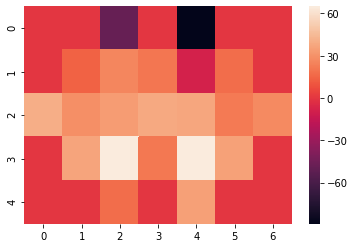

In [74]:
fig = plt.Figure()
fig = heatmap(mapping[:,:,0])

In [78]:
from matplotlib import animation

def init():
      heatmap(mapping[:,:, 0], vmax=.8, square=True)

def animate(i):
    plt.clf()
    data = (mapping[:,:, i])
    heatmap(data, vmax=.8, square=True)

anim = animation.FuncAnimation(fig, animate, init_func=init, frames=20, repeat = True)
anim.to_jshtml()

AttributeError: 'AxesSubplot' object has no attribute 'canvas'

In [165]:
import keras_models.vanPutten as vanPutten
from importlib import reload
reload(vanPutten)
reload(util_funcs)
reload(read)
edfData = read.EdfDataset("train", "01_tcp_ar",filter=True, num_files=10, n_process=6)

In [4]:
import keras_models.vanPutten as vanPutten
from importlib import reload
import wf_analysis.spatialTemporalDatasets as stdata
reload(stdata)
reload(vanPutten)
reload(util_funcs)
reload(read)
edfData = read.EdfDataset("train", "01_tcp_ar",filter=True, num_files=10, n_process=6, max_length=pd.Timedelta(seconds=1))
stdataset =  stdata.BasicSpatialDataset(edfData)

import keras_models.dataGen as dg
from importlib import reload
reload(dg)

<module 'keras_models.dataGen' from '/home/ms994/dbmi_eeg_clustering/keras_models/dataGen.py'>

In [5]:
edg = dg.EdfDataGenerator(dataset=edfData, batch_size=1, labels=np.array([0 for a in range(len(stdataset))]))

In [6]:
x,y = edg[0]

[3]
[0]
(1,)
Starting 6 processes
Process completed
Process completed
Process completed
Process completed
Process completed
Process completed


array([[[[-4.61539490e+00],
         [-5.19943206e+00],
         [-7.11247260e+02],
         ...,
         [-3.62595900e+01],
         [ 5.00186264e+01],
         [ 6.73273640e+01]],

        [[-6.00349888e+00],
         [-6.37776372e+00],
         [ 4.92146670e+02],
         ...,
         [-4.65469724e+01],
         [ 6.67862743e+01],
         [ 8.31416977e+01]],

        [[-6.66627157e+00],
         [-4.36366438e+00],
         [-5.94609664e+02],
         ...,
         [-3.39323274e+01],
         [ 4.67771164e+01],
         [ 6.31550133e+01]],

        ...,

        [[-5.75852637e+00],
         [ 5.61472000e+00],
         [-2.18150948e+03],
         ...,
         [-2.78423690e+01],
         [ 1.96417965e+01],
         [-3.70839325e+00]],

        [[-4.77139906e+01],
         [-1.82875450e+01],
         [ 1.48569771e+03],
         ...,
         [-6.50297984e+01],
         [-1.94466076e+01],
         [-9.35037928e+01]],

        [[-8.00100190e+00],
         [-1.69068066e+00],
         [

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [186]:
x.shape

(5, 626, 5, 7, 1)

In [189]:
cnn = keras.models.Sequential()
cnn.add(keras.layers.Conv3D(filters=3, kernel_size=3, input_shape=(None,5,7, 1), padding='same'))
cnn.add(keras.layers.Conv3D(filters=3, kernel_size=3, padding='same'))

In [191]:
out = cnn.predict(x)

In [192]:
out.shape

(5, 626, 5, 7, 3)

In [151]:
data = edfData[0:2]

Starting 6 processes
retrieving: 0
Process completed
Process completed
Process completed
Process completed


Process Process-255:
Traceback (most recent call last):
  File "/home/ms994/miniconda3/envs/keras-redo/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ms994/miniconda3/envs/keras-redo/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/ms994/dbmi_eeg_clustering/util_funcs.py", line 83, in helper_process
    out_q.put((i, self[i]))
  File "/home/ms994/dbmi_eeg_clustering/data_reader.py", line 254, in __getitem__
    if (self.max_length != None and max(data.index) > self.max_length):
  File "pandas/_libs/tslibs/timedeltas.pyx", line 700, in pandas._libs.tslibs.timedeltas._Timedelta.__richcmp__
TypeError: Cannot compare type 'Timedelta' with type 'str'
Process Process-254:
Traceback (most recent call last):
  File "/home/ms994/miniconda3/envs/keras-redo/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ms994/miniconda3/envs/keras-

In [131]:
[datum[0].shape for datum in data]

[(251, 21), (251, 21), (251, 21), (251, 21), (251, 21)]

In [138]:
hasattr(a, 'abc')


True

In [123]:
x.loc[pd.Timedelta(seconds=0):pd.Timedelta(seconds=1)]

,EEG T5-REF,EEG C3-REF,EEG A1-REF,EEG P4-REF,EEG F8-REF,EEG F3-REF,EEG CZ-REF,EEG O2-REF,EEG A2-REF,EEG P3-REF,...,EEG O1-REF,EEG T4-REF,EEG F4-REF,EEG F7-REF,EEG PZ-REF,EEG FP1-REF,EEG FZ-REF,EEG T3-REF,EEG T6-REF,EEG FP2-REF
00:00:00,35.157700,32.197906,38.789350,61.759533,16.672604,24.989081,36.810101,33.450825,26.260159,61.850325,...,16.745237,21.103216,-7.586816,13.367803,20.376886,-46.082301,19.468974,27.767293,33.922939,-84.922794
00:00:00.008000,57.922281,38.969202,50.701591,81.700298,14.326072,29.744850,47.791571,49.755012,31.837067,81.812128,...,33.518013,21.671860,-15.627683,13.469450,33.996420,-58.177424,21.365785,35.872444,43.599821,-110.775992
00:00:00.016000,61.102378,25.182308,45.431818,68.872260,8.302728,18.186897,39.484468,55.041885,30.934949,66.718345,...,46.549221,22.282554,-16.492458,9.674614,40.016883,-47.659282,13.220255,30.926433,43.235535,-86.479187
00:00:00.024000,70.292855,30.221475,58.372040,78.784754,15.319285,20.159488,44.909037,66.594911,40.005480,74.576315,...,57.910219,30.091795,-14.127180,15.183872,46.136450,-51.553136,14.291568,39.453247,53.584935,-90.666224
00:00:00.032000,86.737198,47.049891,79.837766,94.442382,10.180839,26.976896,56.931572,75.025017,39.132601,100.328233,...,63.076943,24.848606,-22.916307,19.305314,49.012033,-73.480071,19.192458,50.068372,57.334512,-139.163078
00:00:00.040000,77.907799,34.622605,65.293783,65.275325,-8.514003,15.601967,40.379553,62.030909,21.689688,78.194559,...,61.301256,6.468142,-25.503679,6.071447,39.080330,-62.738970,10.316063,43.156264,38.303807,-117.586561
00:00:00.048000,72.459834,33.920470,63.391849,71.589136,2.867055,17.980660,43.390136,65.228457,36.281204,78.472831,...,61.800691,19.985018,-21.136011,11.061588,39.659288,-65.030216,13.200519,43.020130,46.591814,-115.028169
00:00:00.056000,60.606334,33.827936,51.221894,73.125609,14.980636,21.191392,42.234113,58.664524,48.255391,70.917505,...,57.005267,26.342672,-13.311394,8.789505,35.777823,-61.363683,15.413449,32.640742,46.659624,-106.924270
00:00:00.064000,51.212477,35.973433,50.324400,66.511278,14.609618,27.163575,42.334230,46.135348,42.909180,70.134385,...,44.941506,25.244217,-13.979363,11.907923,25.437309,-64.729955,21.712321,28.831212,34.890162,-121.632641
00:00:00.072000,28.672260,25.977298,33.612995,51.353747,9.968310,24.459863,36.410195,27.818342,26.050801,49.948298,...,30.621659,15.240511,-13.313857,2.811022,13.050776,-61.868193,21.019269,17.970178,13.665707,-111.489146
